In [ ]:
import torch
import os
from pathlib import Path
# change base folder
os.chdir('../')
# Load your model definition and dataset
from models import get_model
from types import SimpleNamespace
import yaml
import matplotlib.pyplot as plt
from flame_model.FLAME import FLAMEModel
from renderer.renderer import Renderer
from pytorch3d.transforms import matrix_to_euler_angles
import matplotlib.animation as animation
import numpy as np
from dataset.data_loader_joint_data_batched import get_dataloaders
from scipy.signal import savgol_filter
from base.baseTrainer import load_state_dict
import torch.nn as nn
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2FeatureExtractor
import soundfile as sf
import glob
import subprocess
import torch.nn.functional as F


device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flame    = FLAMEModel(n_shape=300,n_exp=50).to(device)
renderer = Renderer(render_full_head=True).to(device)

In [ ]:
target_dir = "/mnt/fasttalk/demo/video"
import shutil, os; [shutil.rmtree(os.path.join(target_dir, f)) if os.path.isdir(os.path.join(target_dir, f)) else os.remove(os.path.join(target_dir, f)) for f in os.listdir(target_dir)]


In [ ]:
def load_and_flatten_yaml(config_path):
    """
    Loads the YAML file and flattens the structure so that
    all sub-keys under top-level sections (e.g., DATA, NETWORK, etc.)
    appear in a single dictionary without the top-level keys.
    """
    with open(config_path, 'r') as f:
        full_config = yaml.safe_load(f)

    # Flatten the dict by merging all sub-dicts
    flattened_config = {}
    for top_level_key, sub_dict in full_config.items():
        # sub_dict should itself be a dict of key-value pairs
        if isinstance(sub_dict, dict):
            # Merge each sub-key into flattened_config
            for k, v in sub_dict.items():
                flattened_config[k] = v
        else:
            # In case there's a non-dict top-level key (unlikely but possible)
            flattened_config[top_level_key] = sub_dict

    return SimpleNamespace(**flattened_config)

In [ ]:
# ---- Load model (without DDP for eval) ----
def load_model_for_eval(checkpoint_path,cfg):
    model = get_model(cfg)
    model = model.cuda()
   
    checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage.cpu())
    load_state_dict(model, checkpoint['state_dict'], strict=False)
    print("=> Loaded checkpoint '{}'".format(checkpoint_path))
    
    model.eval()
    return model

# ---- Load dataset ----
def load_dataset(cfg,test_config):

    dataset = get_dataloaders(cfg,test_config)

    if not test_config:
        train_loader = dataset['train']
        val_loader = dataset['valid']
        return train_loader, val_loader
    else:
        test_loader = dataset['test']
        return test_loader


# ---- Evaluate some samples ----
def evaluate_samples(model, data_loader, num_samples=10):
    for i, (padded_blendshapes, blendshape_mask, padded_audios, audio_mask) in enumerate(data_loader):
        if i >= num_samples:
            break
       
        padded_blendshapes  = padded_blendshapes.cuda(device, non_blocking=True)
        blendshape_mask     = blendshape_mask.cuda(device, non_blocking=True)
        padded_audios       = padded_audios.cuda(device, non_blocking=True)
        audio_mask          = audio_mask.cuda(device, non_blocking=True)

        with torch.no_grad():
            loss, loss_detail, blendshapes_out  = model(padded_blendshapes,blendshape_mask,padded_audios,audio_mask,criterion=nn.MSELoss())
        
        print("loss_blendshapes: ", loss_detail[0].item(), "- loss_reg:", loss_detail[1].item())

        render_comparison(padded_blendshapes.squeeze(), blendshapes_out.squeeze(), i)


def get_vertices_from_blendshapes(expr, gpose, jaw, eyelids):

    # Load the encoded file
    expr_tensor    = expr.to(device)
    gpose_tensor   = gpose.to(device)
    jaw_tensor     = jaw.to(device)
    eyelids_tensor = eyelids.to(device)

    target_shape_tensor = torch.zeros(expr_tensor.shape[0], 300).expand(expr_tensor.shape[0], -1).to(device)

    I = matrix_to_euler_angles(torch.cat([torch.eye(3)[None]], dim=0),"XYZ").to(device)

    eye_r    = I.clone().to(device).squeeze()
    eye_l    = I.clone().to(device).squeeze()
    eyes     = torch.cat([eye_r,eye_l],dim=0).expand(expr_tensor.shape[0], -1).to(device)

    pose = torch.cat([gpose_tensor, jaw_tensor], dim=-1).to(device)

    flame_output_only_shape,_ = flame.forward(shape_params=target_shape_tensor, 
                                              expression_params=expr_tensor, 
                                              pose_params=pose, 
                                              eye_pose_params=eyes)
    return flame_output_only_shape.detach()

# Assumes flame and renderer are already defined and on correct device

def render_comparison(blendshapes_gt, blendshapes_pred, index=None, name=None):
    # ==== Align lengths ====
    min_len = min(blendshapes_gt.shape[0], blendshapes_pred.shape[0])
    blendshapes_gt = blendshapes_gt[:min_len]
    blendshapes_pred = blendshapes_pred[:min_len]
    
    # ==== Split GT and predicted blendshapes ====
    expr_gt     = blendshapes_gt[:, :50]
    gpose_gt    = blendshapes_gt[:, 50:53]
    jaw_gt      = blendshapes_gt[:, 53:56]
    eyelids_gt  = blendshapes_gt[:, 56:]

    expr_pr     = blendshapes_pred[:, :50]
    gpose_pr    = blendshapes_pred[:, 50:53]
    jaw_pr      = blendshapes_pred[:, 53:56]
    eyelids_pr = blendshapes_pred[:, 56:]

    # Apply Savitzky-Golay filter along the time axis (axis=0)
    #gpose_pr_smooth_np = savgol_filter(gpose_pr.detach().cpu().numpy(), window_length=7, polyorder=2, axis=0)
    gpose_pr_smoothed = gpose_pr #torch.from_numpy(gpose_pr_smooth_np).to(gpose_pr.device)

    # ==== Generate vertices ====
    verts_gt = get_vertices_from_blendshapes(expr_gt, gpose_gt, jaw_gt, eyelids_gt) # vertice_gt.reshape(-1,5023,3)
    verts_pr = get_vertices_from_blendshapes(expr_pr, gpose_pr_smoothed, jaw_pr, eyelids_pr) # vertice_pred.reshape(-1,5023,3) 

    # ==== Camera ====
    cam = torch.tensor([5, 0, 0], dtype=torch.float32).unsqueeze(0).to(verts_gt.device)
    cam = cam.expand(verts_gt.shape[0], -1)

    # ==== Render both sequences ====
    frames_gt = renderer.forward(verts_gt, cam)['rendered_img']         # [T, 3, H, W]
    frames_pr = renderer.forward(verts_pr, cam)['rendered_img']         # [T, 3, H, W]

    # ==== Prepare output folder ====
    os.makedirs("demo/video", exist_ok=True)
    if index is not None:
        video_file = f"demo/video/sample_{index:03d}.mp4"
    else:
        video_file = f"demo/video/{name}.mp4"

    # ==== Create animation ====
    def update(frame_idx, gt_seq, pr_seq, axes):
        gt = gt_seq[frame_idx].detach().cpu().numpy().transpose(1, 2, 0)
        pr = pr_seq[frame_idx].detach().cpu().numpy().transpose(1, 2, 0)
        combined = np.concatenate([(gt * 255).astype(np.uint8), (pr * 255).astype(np.uint8)], axis=1)
        axes.clear()
        axes.imshow(combined)
        axes.axis("off")

    fig, ax = plt.subplots(figsize=(10, 5))
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=frames_gt.shape[0],
        fargs=(frames_gt, frames_pr, ax),
        interval=100
    )
    ani.save(video_file, writer='ffmpeg', fps=25)
    plt.close(fig)

def render(blendshapes_pred, index=None, name=None, audio_dir=None):
    # ==== Split GT and predicted blendshapes ====
    expr_pr     = blendshapes_pred[:, :50]
    gpose_pr    = blendshapes_pred[:, 50:53] 
    jaw_pr      = blendshapes_pred[:, 53:56]
    eyelids_pr  = blendshapes_pred[:, 56:]

    # Apply Savitzky-Golay filter along the time axis (axis=0)
    #gpose_pr_smooth_np = savgol_filter(gpose_pr.detach().cpu().numpy(), window_length=7, polyorder=2, axis=0)
    gpose_pr_smoothed = gpose_pr #torch.from_numpy(gpose_pr_smooth_np).to(gpose_pr.device)

    # ==== Generate vertices ====
    verts_pr = get_vertices_from_blendshapes(expr_pr, gpose_pr_smoothed, jaw_pr, eyelids_pr) # vertice_pred.reshape(-1,5023,3) 

    # ==== Camera ====
    cam = torch.tensor([5, 0, 0], dtype=torch.float32).unsqueeze(0).to(verts_pr.device)
    cam = cam.expand(verts_pr.shape[0], -1)

    # ==== Render both sequences ====
    frames_pr = renderer.forward(verts_pr, cam)['rendered_img']         # [T, 3, H, W]

    # ==== Prepare output folder ====
    os.makedirs("demo/video", exist_ok=True)
    if index is not None:
        video_file = f"demo/video/sample_{index:03d}.mp4"
    else:
        video_file = f"demo/video/{name}.mp4"

    # ==== Create animation ====
    def update(frame_idx, pr_seq, axes):
        pr = pr_seq[frame_idx].detach().cpu().numpy().transpose(1, 2, 0)
        scaled = (pr * 255).astype(np.uint8)
        axes.clear()
        axes.imshow(scaled)
        axes.axis("off")

    fig, ax = plt.subplots(figsize=(5, 5))
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=frames_pr.shape[0],
        fargs=(frames_pr, ax),
        interval=100
    )
    ani.save(video_file, writer='ffmpeg', fps=25)
    plt.close(fig)

    # =============== Add audio to the video ===============
    
    # Add audio to the video
    audio_file = f'{audio_dir}/{name}.wav'
    output_with_audio = f'demo/video/{name}_with_audio.mp4'
    if os.path.exists(audio_file):
        cmd = f'ffmpeg -y -i {video_file} -i {audio_file} -c:v copy -c:a aac -strict experimental {output_with_audio}'
        subprocess.run(cmd, shell=True)
        print(f"Video with audio saved as {output_with_audio}")
    else:
        print(f"Audio file {audio_file} not found")

In [ ]:
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

global cfg

#cfg = load_and_flatten_yaml("config/joint_data/stage2interactive.yaml")
cfg = load_and_flatten_yaml("config/talkinghead-1kh/stage2.yaml")

cfg.batch_size = 1

checkpoint_path = "/mnt/fasttalk/logs/talkinghead/talkinghead-s2/model_140/model.pth.tar" #"/mnt/fasttalk/logs/joint_data/joint_data_finetune_s2/model_50/model.pth.tar" #"/root/Projects/fasttalk/logs/joint_data/joint_data_custom_s2/model_95/model.pth.tar"
model = load_model_for_eval(checkpoint_path,cfg)


In [ ]:
val_loader = load_dataset(cfg, test_config=True)  
num_samples = 5
sample = next(iter(val_loader)),   # Get a sample from the validation set
target_style = sample[0][0]
target_style = target_style.to(device, non_blocking=True)
target_style.shape


In [ ]:
target_style = torch.load("/mnt/fasttalk/demo/styles/style_2.npz",map_location=device)
target_style.shape

In [ ]:
style = np.load("/mnt/Datasets/expressive_ft/npz/video_015.npz")# np.load("/mnt/Datasets/ARTalk_data/npz/0Uzp8S5tCDM2.npz")
exp = style["exp"].reshape(-1, 50)
gpose = style["pose"].reshape(-1, 3)
jaw = style["jaw"].reshape(-1, 3)

# eyelids: all ones
eyelids = np.ones((exp.shape[0], 2), dtype=np.float32)

# concat to [T,58]
concat = np.concatenate([exp, gpose, jaw, eyelids], axis=1)

# pytorch tensor
target_style_tensor = torch.from_numpy(concat).float()          # [T,58]

In [ ]:
style.keys()

In [ ]:
target_style = target_style_tensor.unsqueeze(0).to(device) # [1,T,58]
target_style.shape

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '500x500', '-pix_fmt', 'rgba', '-framerate', '25', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'demo/video/video_008.mp4']' returned non-zero exit status 255.

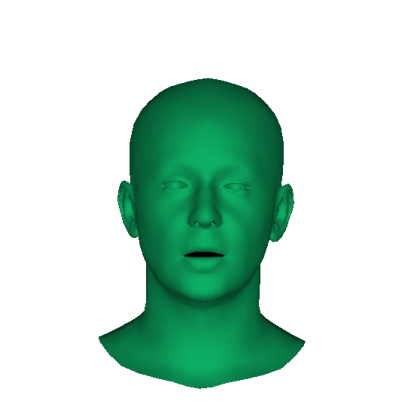

In [9]:
# raw audio test
audio_dir =  "/mnt/Datasets/expressive_ft/wav" #  "demo/input" # 
for wav_file in glob.glob(os.path.join(audio_dir,"*.wav")):
    print('Generating facial animation for {}...'.format(wav_file))
    test_name       = os.path.basename(wav_file).split(".")[0]
    speech_array, _ = librosa.load(wav_file, sr=16000)

    # Use Wav2Vec audio features
    processor = Wav2Vec2FeatureExtractor.from_pretrained(cfg.wav2vec2model_path)
    print(cfg.wav2vec2model_path)

    audio_feature = np.squeeze(processor(speech_array, sampling_rate=16000).input_values)
    audio_feature = np.reshape(audio_feature, (-1, audio_feature.shape[0]))
    audio_feature = torch.FloatTensor(audio_feature).to(device='cuda')

    with torch.no_grad():
        #blendshapes_out  = model.predict(audio_feature, target_style=target_style)
        blendshapes_out  = model.predict_no_quantizer(audio_feature, target_style=target_style)
        #blendshapes_out  = model.predict_no_quantizer(audio_feature)

        
        #x = blendshapes_out[:, :, 50:53]
        #print( x.mean(axis=1, keepdims=True))
        #x  = x - x.mean(axis=1, keepdims=True)
        #blendshapes_out[:, :, 50:53] = x

        #blendshapes_out[:, :, 50:53] = match_mean_std(x, style_mean, style_std)
       # print(" MEAN:",blendshapes_out[:,:,50:53].mean())
       # print(" STD:",blendshapes_out[:,:,50:53].std())

    render(blendshapes_out.squeeze(), name=os.path.splitext(os.path.basename(wav_file))[0], audio_dir=audio_dir)


In [ ]:
target_style = np.load("/mnt/fasttalk/demo/styles/espresso.npz", allow_pickle=True)


if 'pose_params' in target_style:
    expr   = target_style['expression_params'].reshape(-1, 50)
    jaw    = target_style["jaw_params"].reshape(-1, 3)
    gpose  = target_style["pose_params"].reshape(-1, 3)
    gpose  = gpose - gpose.mean(axis=0, keepdims=True)

# Apply Savitzky-Golay filter along the time axis for gpose (removes tracker's flickering) (axis=0)
gpose = savgol_filter(gpose, window_length=7, polyorder=2, axis=0)
eyelids = np.ones((gpose.shape[0], 2))

target_style_concat = torch.Tensor(np.concatenate([expr, gpose, jaw, eyelids], axis=-1)).unsqueeze(0).to(device)


In [ ]:
#target_style_concat = torch.load("/mnt/smirk/results/1051_TIE_HAP_XX_params.pt",map_location=device).unsqueeze(0) # Happy 30:
target_style_concat = torch.load("/mnt/smirk/results/1083_ITH_SAD_XX_params.pt",map_location=device).unsqueeze(0) # Sad 30:
#target_style_concat = torch.load("/mnt/smirk/results/1091_IEO_ANG_HI_params.pt",map_location=device).unsqueeze(0) # Ang


#pose_cols = slice(50, 53) 
#pose_seq   = target_style_concat[:, :, pose_cols]
#pose_seq_centerd  = pose_seq - pose_seq.mean(axis=1, keepdims=True)

#target_style_concat[:, :, pose_cols] = pose_seq_centerd

target_style_concat = target_style_concat[:,:80,:]
target_style_concat.shape



In [ ]:
target_style_happy = target_style_concat
target_style_happy.shape

In [ ]:
#target_style_happy[:,:,30:].shape

In [ ]:
target_style_lips = torch.load("/mnt/fasttalk/demo/styles/style_2.npz",map_location=device)[:,:80,:] # SAD
#target_style_lips = torch.load("/mnt/fasttalk/demo/styles/style_4.npz",map_location=device)[:,:80,:] # HAPPY
target_style_lips.shape



In [ ]:
#target_style_happy[:,:,30:] = target_style_concat[:,:,30:]

In [ ]:
#target_style_concat = target_style_happy

In [ ]:
#target_style_concat = torch.cat([target_style_happy, target_style_concat, target_style_happy, target_style_concat], dim=1) # Duplicate for batch size 2

In [ ]:
target_style_blend=0.1*target_style_lips[:,:,:50]+0.9*target_style_happy[:,:,:50] # sad
#target_style_blend=0.1*target_style_lips[:,:,:50]+0.9*target_style_happy[:,:,:50] # happy

In [ ]:
target_style_concat = target_style_lips
target_style_concat[:,:,:50] = target_style_blend 

In [ ]:
target_style_concat = torch.cat([target_style_concat, target_style_concat, target_style_concat], dim=1) # Duplicate for batch size 2

In [ ]:
pose_cols = slice(0, 56) 
pose_seq   = target_style_concat[:, :, pose_cols]
pose_seq_smoothed  = savgol_filter(pose_seq.squeeze(0).cpu().numpy(), window_length=7, polyorder=2, axis=0)
target_style_concat[:, :, pose_cols] = torch.Tensor(pose_seq_smoothed).unsqueeze(0).to(device)

In [ ]:
#target_style = torch.load("/root/Projects/fasttalk/demo/styles/celeb.npz",map_location=device)
#target_style.shape

In [ ]:
target_style =  target_style_concat # target_style_lips 
target_style.shape

In [ ]:
# Save target style
array = target_style.detach().cpu().numpy()
torch.save(array,"/mnt/fasttalk/demo/new_styles/happy.npz")

In [ ]:
render(target_style.squeeze() , name="happy", audio_dir= None)

In [ ]:
# ── Sample styles ───────────────────────────────────────────
#num_samples     = 15         
#collected_styles = []        
#data_iter = iter(train_loader)   
#for idx in range(num_samples):
#    sample = next(data_iter)              
#    target_style = sample[0][0].to(device, non_blocking=True)
#    collected_styles.append(target_style)
#    render(target_style.squeeze(), name=f"style_{idx:02d}", audio_dir=None)

In [ ]:
#torch.save(target_style, "demo/styles/style_3.npz")

In [ ]:
render_comparison(target_style.squeeze(), target_style.squeeze(), 0)

In [ ]:
#style_mean = target_style[:,:,50:53].mean()
#style_std  = target_style[:,:,50:53].std()
#print("Style mean:", style_mean, "Style std:", style_std)

In [ ]:
#  teacher-forcing test
for i, (padded_blendshapes, blendshape_mask, padded_audios, audio_mask) in enumerate(val_loader):
    if i >= num_samples:
        break
    
    padded_blendshapes = padded_blendshapes.cuda(device, non_blocking=True)
    blendshape_mask    = blendshape_mask.cuda(device, non_blocking=True)
    padded_audios      = padded_audios.cuda(device, non_blocking=True)
    audio_mask         = audio_mask.cuda(device, non_blocking=True)

    with torch.no_grad():
        loss, loss_detail, blendshapes_out  = model(padded_blendshapes,blendshape_mask,padded_audios,audio_mask,criterion=nn.MSELoss(), target_style=target_style)
    
    print("loss_blendshapes: ", loss_detail[0].item(), "- loss_reg:", loss_detail[1].item())

    render_comparison(padded_blendshapes.squeeze(), blendshapes_out.squeeze(), i)

In [ ]:
#  autoregression-only test
for i, (padded_blendshapes, blendshape_mask, padded_audios, audio_mask) in enumerate(val_loader):
    if i >= num_samples:
        break
    
    print("Sample: ", i)
    padded_blendshapes = padded_blendshapes.cuda(device, non_blocking=True)
    blendshape_mask    = blendshape_mask.cuda(device, non_blocking=True)
    padded_audios      = padded_audios.cuda(device, non_blocking=True)
    audio_mask         = audio_mask.cuda(device, non_blocking=True)

    with torch.no_grad():
        blendshapes_out  = model.predict(padded_audios, target_style=target_style)
    
    render_comparison(padded_blendshapes.squeeze(), blendshapes_out.squeeze(), i)

In [ ]:
def match_mean_std(x, target_mean, target_std, dims=(0, 1), eps=1e-6):
    mean_current = x.mean(dim=dims, keepdim=True)
    std_current = x.std(dim=dims, keepdim=True).clamp(min=eps)

    target_mean = target_mean.view(*([1] * len(dims)), -1)
    target_std = target_std.view(*([1] * len(dims)), -1)

    x_norm = (x - mean_current) / std_current
    x_rescaled = x_norm * target_std + target_mean
    return x_rescaled

In [ ]:
target_style = torch.load("/mnt/fasttalk/demo/styles/style_0.npz")

In [ ]:
target_style.shape

In [ ]:
# raw audio test
audio_dir = "/mnt/Datasets/expressive_ft/wav"# "demo/input"
for wav_file in glob.glob(os.path.join(audio_dir,"*.wav")):
    print('Generating facial animation for {}...'.format(wav_file))
    test_name       = os.path.basename(wav_file).split(".")[0]
    speech_array, _ = librosa.load(wav_file, sr=16000)

    # Use Wav2Vec audio features
    processor = Wav2Vec2FeatureExtractor.from_pretrained(cfg.wav2vec2model_path)
    print(cfg.wav2vec2model_path)

    audio_feature = np.squeeze(processor(speech_array, sampling_rate=16000).input_values)
    audio_feature = np.reshape(audio_feature, (-1, audio_feature.shape[0]))
    audio_feature = torch.FloatTensor(audio_feature).to(device='cuda')

    with torch.no_grad():
        #blendshapes_out  = model.predict(audio_feature, target_style=target_style)
        blendshapes_out  = model.predict_no_quantizer(audio_feature, target_style=target_style)

        
        #x = blendshapes_out[:, :, 50:53]
        #print( x.mean(axis=1, keepdims=True))
        #x  = x - x.mean(axis=1, keepdims=True)
        #blendshapes_out[:, :, 50:53] = x

        #blendshapes_out[:, :, 50:53] = match_mean_std(x, style_mean, style_std)
       # print(" MEAN:",blendshapes_out[:,:,50:53].mean())
       # print(" STD:",blendshapes_out[:,:,50:53].std())

    render(blendshapes_out.squeeze(), name=os.path.splitext(os.path.basename(wav_file))[0], audio_dir=audio_dir)


In [ ]:
evaluate_samples(model, train_loader, num_samples=5)

In [ ]:
test_loader = load_dataset(cfg, test_config=True)

In [ ]:

evaluate_samples(model, test_loader, num_samples=5)